# 09__cis_trans_effects

in this notebook, i investigate the co-occurrence of cis and trans effects

In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from itertools import combinations 
from scipy.integrate import cumtrapz
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# import utils
sys.path.append("../../../utils")
from plotting_utils import *


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

In [4]:
QUANT_ALPHA = 0.05

## functions

In [5]:
def cis_trans_status(row):
    if row.cis_status_one == "significant cis effect":
        if row.trans_status_one == "significant trans effect":
            if "higher in human" in row.cis_status_det_one:
                if "higher in human" in row.trans_status_det_one:
                    return "cis/trans directional"
                else:
                    return "cis/trans compensatory"
            else:
                if "higher in human" in row.trans_status_det_one:
                    return "cis/trans compensatory"
                else:
                    return "cis/trans directional"
        else:
            return "cis effect only"
    else:
        if row.trans_status_one == "significant trans effect":
            return "trans effect only"
        else:
            return "no cis or trans effects"

## variables

In [6]:
data_f = "../../../data/02__mpra/03__results/all_processed_results.txt"

## 1. import data

In [7]:
data = pd.read_table(data_f, sep="\t")
data.head()

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status,trans_human_status_det,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.325920,-0.050780,0.991115,no cis/trans int. effect,no cis/trans int. effect
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.533476,-0.405629,0.908445,no cis/trans int. effect,no cis/trans int. effect
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.270223,-0.210732,0.960813,no cis/trans int. effect,no cis/trans int. effect
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,trans effect\n(higher in mouse),no trans effect,significant trans effect,trans effect\n(higher in mouse),0.449668,-0.740913,0.152051,no cis/trans int. effect,no cis/trans int. effect
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.270646,-0.528464,0.379849,no cis/trans int. effect,no cis/trans int. effect


In [8]:
data["cis_trans_status"] = data.apply(cis_trans_status, axis=1)

## 2. filter data

In [9]:
data = data[~pd.isnull(data["minimal_biotype_hg19"])]
len(data)

2952

In [10]:
data_filt = data[((data["HUES64_padj_hg19"] < QUANT_ALPHA) | (data["mESC_padj_mm9"] < QUANT_ALPHA))]
len(data_filt)

1655

In [11]:
data_filt_sp = data_filt.drop("orig_species", axis=1)
data_filt_sp.drop_duplicates(inplace=True)
len(data_filt_sp)

1644

In [12]:
data_filt_sp.cis_trans_status.value_counts()

no cis or trans effects    850
cis effect only            501
trans effect only          134
cis/trans directional       95
cis/trans compensatory      64
Name: cis_trans_status, dtype: int64

## 3. count cis trans effects

In [13]:
# fisher's exact to see if cis/trans effects are enriched
cis_trans = len(data_filt_sp[data_filt_sp["cis_trans_status"].isin(["cis/trans directional", "cis/trans compensatory"])])
cis_no_trans = len(data_filt_sp[data_filt_sp["cis_trans_status"] == "cis effect only"])
trans_no_cis = len(data_filt_sp[data_filt_sp["cis_trans_status"] == "trans effect only"])
n_no_cis_trans = len(data_filt_sp[data_filt_sp["cis_trans_status"] == "no cis or trans effects"])

# fisher's exact test
arr = np.zeros((2, 2))
arr[0, 0] = cis_trans
arr[0, 1] = cis_no_trans
arr[1, 0] = trans_no_cis
arr[1, 1] = n_no_cis_trans
print(arr)

odds, p = stats.fisher_exact(arr)
print(odds)
print(p)

[[ 159.  501.]
 [ 134.  850.]]
2.0131379033
8.59951711423e-08


In [14]:
stats.binom_test(95, 159)

0.017077471627514162

In [15]:
cis_trans = data_filt_sp[data_filt_sp["cis_trans_status"].isin(["cis/trans directional", "cis/trans compensatory"])]
tmp = cis_trans[((cis_trans["minimal_biotype_hg19"] == "mRNA") & (cis_trans["minimal_biotype_mm9"] == "mRNA"))]
tmp.cis_trans_status.value_counts()

cis/trans compensatory    22
cis/trans directional     16
Name: cis_trans_status, dtype: int64

In [16]:
tmp = cis_trans[((cis_trans["minimal_biotype_hg19"] == "lncRNA") & (cis_trans["minimal_biotype_mm9"] == "lncRNA"))]
tmp.cis_trans_status.value_counts()

cis/trans compensatory    16
cis/trans directional     12
Name: cis_trans_status, dtype: int64

## 4. look at directionality of cis/trans

In [17]:
min_switch_order = ["CAGE turnover - eRNA", "CAGE turnover - lncRNA", "CAGE turnover - mRNA", 
                    "eRNA", "lncRNA", "mRNA"]
min_switch_pal = {"CAGE turnover - eRNA": sns.color_palette("Set2")[2], 
                  "CAGE turnover - lncRNA": sns.color_palette("Set2")[2],
                  "CAGE turnover - mRNA": sns.color_palette("Set2")[2],
                  "eRNA": sns.color_palette("Set2")[7], 
                  "lncRNA": sns.color_palette("Set2")[7], 
                  "mRNA": sns.color_palette("Set2")[7]}

In [18]:
def cage_status(row):
    if "CAGE turnover" in row.biotype_switch_minimal:
        return "turnover"
    else:
        return "conserved"

In [19]:
def one_biotype(row):
    if row.minimal_biotype_hg19 == "no CAGE activity":
        return row.minimal_biotype_mm9
    elif row.biotype_switch_minimal == "biotype switch":
        return "biotype switch"
    else:
        return row.minimal_biotype_hg19

In [20]:
pal = {"conserved": sns.color_palette("Set2")[7], "turnover": sns.color_palette("Set2")[2]}

In [21]:
df = data_filt_sp

159
          index    0        perc  tmp
0         total  159  100.000000  tmp
1   directional   95   59.748428  tmp
2  compensatory   64   40.251572  tmp


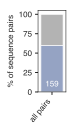

In [22]:
res = {}
cis_trans = df[(df["cis_status_one"] == "significant cis effect") & 
               (df["trans_status_one"] == "significant trans effect")]
tots = len(cis_trans)
print(tots)
res["total"] = [tots]
direc = cis_trans[((cis_trans["cis_status_det_one"].str.contains("higher in human") & 
                    cis_trans["trans_status_det_one"].str.contains("higher in human")) |
                   (cis_trans["cis_status_det_one"].str.contains("higher in mouse") &
                    cis_trans["trans_status_det_one"].str.contains("higher in mouse")))]    
direc = len(direc)
res["directional"] = [direc]

comp = cis_trans[((cis_trans["cis_status_det_one"].str.contains("higher in human") & 
                    cis_trans["trans_status_det_one"].str.contains("higher in mouse")) |
                   (cis_trans["cis_status_det_one"].str.contains("higher in mouse") &
                    cis_trans["trans_status_det_one"].str.contains("higher in human")))]
comp = len(comp)
res["compensatory"] = [comp]
res = pd.DataFrame.from_dict(res, orient="index").reset_index()
res["perc"] = (res[0]/tots)*100
res["tmp"] = "tmp"
print(res)

fig, ax = plt.subplots(figsize=(0.5, 1.5), nrows=1, ncols=1)
sns.barplot(data=res[res["index"] == "total"], 
            x="tmp", y="perc", color=sns.color_palette("Set2")[7], ax=ax)
sns.barplot(data=res[res["index"] == "directional"], 
            x="tmp", y="perc", color=sns.color_palette("Set2")[2], ax=ax)

ax.set_xlabel("")
ax.set_ylabel("% of sequence pairs")
ax.set_xticklabels(["all pairs"], rotation=50, ha="right", va="top")

ax.annotate(str(tots), xy=(0, 5), xycoords="data", xytext=(0, 0), 
            textcoords="offset pixels", ha='center', va='bottom', 
            color="white", size=fontsize)

# fig.savefig("direc_v_comp.pdf", dpi="figure", bbox_inches="tight")

CAGE turnover - eRNA perc sig: 100.0
CAGE turnover - lncRNA perc sig: 64.7058823529
CAGE turnover - mRNA perc sig: 60.0
eRNA perc sig: 75.0
lncRNA perc sig: 42.8571428571
mRNA perc sig: 42.1052631579


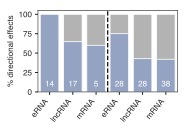

In [23]:
cis_trans = df[(df["cis_status_one"] == "significant cis effect") & 
               (df["trans_status_one"] == "significant trans effect")]
tots = cis_trans.groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()

direc = cis_trans[((cis_trans["cis_status_det_one"].str.contains("higher in human") & 
                    cis_trans["trans_status_det_one"].str.contains("higher in human")) |
                   (cis_trans["cis_status_det_one"].str.contains("higher in mouse") &
                    cis_trans["trans_status_det_one"].str.contains("higher in mouse")))]
sig = direc.groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
clean_sig = tots.merge(sig, on="biotype_switch_minimal", how="left").fillna(0)
clean_sig["percent_sig"] = (clean_sig["hg19_id_y"]/clean_sig["hg19_id_x"])*100
clean_sig["percent_tot"] = (clean_sig["hg19_id_x"]/clean_sig["hg19_id_x"])*100

fig = plt.figure(figsize=(2.5, 1.5))
ax = sns.barplot(data=clean_sig, x="biotype_switch_minimal", y="percent_tot", 
                 order=min_switch_order, color=sns.color_palette("Set2")[7])
sns.barplot(data=clean_sig, x="biotype_switch_minimal", y="percent_sig", 
            order=min_switch_order, color=sns.color_palette("Set2")[2])

ax.set_xticklabels(["eRNA", "lncRNA", "mRNA", "eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("% directional effects")
ax.axvline(x=2.5, linestyle="dashed", color="black")

for i, l in enumerate(min_switch_order):
    sub = clean_sig[clean_sig["biotype_switch_minimal"] == l]
    print("%s perc sig: %s" % (l, sub["percent_sig"].iloc[0]))
    n = sub["hg19_id_x"].iloc[0]
    ax.annotate(str(n), xy=(i, 5), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)

plt.show()
fig.savefig("Fig6C.pdf", dpi="figure", bbox_inches="tight")
plt.close()

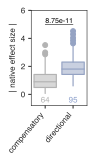

In [24]:
cis_trans_order = ["cis/trans compensatory", "cis/trans directional"]
cis_trans_pal = {"cis/trans compensatory": sns.color_palette("Set2")[7], 
                 "cis/trans directional": sns.color_palette("Set2")[2]}
df["abs_logFC_native"] = np.abs(df["logFC_native"])

fig = plt.figure(figsize=(1, 1.75))
ax = sns.boxplot(data=df, x="cis_trans_status", y="abs_logFC_native", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=cis_trans_order, palette=cis_trans_pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(["compensatory", "directional"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel(r'$\vert$ native effect size $\vert$')

for i, l in enumerate(cis_trans_order):
    sub = df[df["cis_trans_status"] == l]
    n = len(sub)
    color = cis_trans_pal[l]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)
    
sub1 = df[df["cis_trans_status"] == "cis/trans compensatory"]
sub2 = df[df["cis_trans_status"] == "cis/trans directional"]
    
vals1 = np.asarray(sub1["abs_logFC_native"])
vals2 = np.asarray(sub2["abs_logFC_native"])

vals1 = vals1[~np.isnan(vals1)]
vals2 = vals2[~np.isnan(vals2)]

u, pval = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
annotate_pval(ax, 0, 1, 5, 0, 5, pval, fontsize-1)
ax.set_ylim((-0.8, 6))
fig.savefig("Fig6F.pdf", dpi="figure", bbox_inches="tight")

In [25]:
df.columns

Index(['hg19_id', 'chr_tss_hg19', 'start_tss_hg19', 'biotype_hg19',
       'cage_id_hg19', 'name_peak_hg19', 'minimal_biotype_hg19',
       'stem_exp_hg19', 'mm9_id', 'chr_tss_mm9', 'start_tss_mm9',
       'biotype_mm9', 'cage_id_mm9', 'name_peak_mm9', 'minimal_biotype_mm9',
       'stem_exp_mm9', 'tss_tile_num', 'biotype_switch_minimal', 'HUES64_hg19',
       'mESC_hg19', 'HUES64_mm9', 'mESC_mm9', 'HUES64_padj_hg19',
       'mESC_padj_hg19', 'HUES64_padj_mm9', 'mESC_padj_mm9', 'logFC_native',
       'fdr_native', 'native_status', 'native_status_det', 'logFC_cis_HUES64',
       'fdr_cis_HUES64', 'logFC_cis_mESC', 'fdr_cis_mESC', 'cis_HUES64_status',
       'cis_mESC_status', 'cis_HUES64_status_det', 'cis_mESC_status_det',
       'cis_status_one', 'cis_status_det_one', 'logFC_cis_one',
       'logFC_trans_human', 'fdr_trans_human', 'logFC_trans_mouse',
       'fdr_trans_mouse', 'trans_human_status', 'trans_mouse_status',
       'trans_human_status_det', 'trans_mouse_status_det', 'trans_

3.00638334117e-06


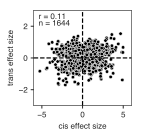

In [28]:
fig, ax = plt.subplots(figsize=(1.75, 1.75), nrows=1, ncols=1)

ax.scatter(df["logFC_cis_one"], df["logFC_trans_one"], s=12, alpha=1, 
           color="black", linewidths=0.5, edgecolors="white")

plt.xlabel("cis effect size")
plt.ylabel("trans effect size")

ax.axhline(y=0, color="black", linestyle="dashed")
ax.axvline(x=0, color="black", linestyle="dashed")
ax.set_xlim((-6, 6))
ax.set_ylim((-3, 3))

# annotate corr
no_nan = df[(~pd.isnull(df["logFC_cis_one"])) & (~pd.isnull(df["logFC_trans_one"]))]
r, p = spearmanr(no_nan["logFC_cis_one"], no_nan["logFC_trans_one"])
print(p)
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
plt.show()
fig.savefig("cis_effect_bw_cells_scatter.sig_status_color.pdf", dpi="figure", bbox_inches="tight")
plt.close()

## 5. plot some examples

### compensatory

In [25]:
ex = df[df["hg19_id"] == "h.1433"]
ex = ex[["hg19_id", "mm9_id", "minimal_biotype_hg19", "minimal_biotype_mm9", "HUES64_hg19", "HUES64_mm9",
         "mESC_hg19", "mESC_mm9", "trans_human_status_det", "fdr_trans_human", "trans_mouse_status_det", 
         "fdr_trans_mouse", "cis_HUES64_status_det", "fdr_cis_HUES64", "cis_mESC_status_det", "fdr_cis_mESC",
         "logFC_trans_human", "logFC_trans_mouse", "logFC_cis_HUES64", "logFC_cis_mESC"]]
ex

,hg19_id,mm9_id,minimal_biotype_hg19,minimal_biotype_mm9,HUES64_hg19,HUES64_mm9,mESC_hg19,mESC_mm9,trans_human_status_det,fdr_trans_human,trans_mouse_status_det,fdr_trans_mouse,cis_HUES64_status_det,fdr_cis_HUES64,cis_mESC_status_det,fdr_cis_mESC,logFC_trans_human,logFC_trans_mouse,logFC_cis_HUES64,logFC_cis_mESC
2575,h.1433,m.1276,eRNA,eRNA,5.7626,9.174341,2.341169,8.04181,trans effect\n(higher in human),2.640306e-10,no trans effect,0.9048,cis effect\n(higher in mouse),2.725712e-07,cis effect\n(higher in mouse),1.754477e-17,-0.725202,0.016883,0.773398,1.547024


In [26]:
ex = pd.melt(ex, id_vars=["hg19_id", "mm9_id", "minimal_biotype_hg19", "minimal_biotype_mm9"])
ex = ex[ex["variable"].isin(["HUES64_hg19", "HUES64_mm9", "mESC_hg19", "mESC_mm9",
                             "fdr_cis_HUES64", "fdr_cis_mESC",
                             "fdr_trans_human", "fdr_trans_mouse", "logFC_cis_HUES64", "logFC_cis_mESC",
                             "logFC_trans_human", "logFC_trans_mouse"])]

In [27]:
ex["cell"] = ex["variable"].str.split("_", expand=True)[0]
ex["seq"] = ex["variable"].str.split("_", expand=True)[1]
ex.head()

,hg19_id,mm9_id,minimal_biotype_hg19,minimal_biotype_mm9,variable,value,cell,seq
0,h.1433,m.1276,eRNA,eRNA,HUES64_hg19,5.7626,HUES64,hg19
1,h.1433,m.1276,eRNA,eRNA,HUES64_mm9,9.17434,HUES64,mm9
2,h.1433,m.1276,eRNA,eRNA,mESC_hg19,2.34117,mESC,hg19
3,h.1433,m.1276,eRNA,eRNA,mESC_mm9,8.04181,mESC,mm9
5,h.1433,m.1276,eRNA,eRNA,fdr_trans_human,2.64031e-10,fdr,trans


In [28]:
order = ["HUES64", "mESC"]
hue_order = ["hg19", "mm9"]
pal = {"hg19": sns.color_palette("Set2")[1], "mm9": sns.color_palette("Set2")[0]}

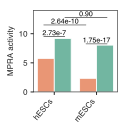

In [29]:
fig = plt.figure(figsize=(1.5, 1.5))

sub = ex[ex["cell"].isin(["HUES64", "mESC"])]
ax = sns.barplot(data=sub, x="cell", y="value", hue="seq", order=order, hue_order=hue_order, palette=pal)
ax.set_xticklabels(["hESCs", "mESCs"], rotation=50, va="top", ha="right")
ax.set_ylabel("MPRA activity")
ax.set_xlabel("")
ax.get_legend().remove()

ax.set_ylim((0, 14))
annotate_pval(ax, -0.25, 0.25, 9.5, 0, 9.5, ex[ex["variable"] == "fdr_cis_HUES64"]["value"].iloc[0], fontsize-1)
annotate_pval(ax, 0.75, 1.25, 8.25, 0, 8.25, ex[ex["variable"] == "fdr_cis_mESC"]["value"].iloc[0], fontsize-1)
annotate_pval(ax, -0.25, 0.75, 11.5, 0, 11.5, ex[ex["variable"] == "fdr_trans_human"]["value"].iloc[0], fontsize-1)
annotate_pval(ax, 0.25, 1.25, 12.75, 0, 12.75, ex[ex["variable"] == "fdr_trans_mouse"]["value"].iloc[0], fontsize-1)

# fig.savefig("compensatory_example_barplot.pdf", dpi="figure", bbox_inches="tight")

In [30]:
ex_sub = ex[ex["variable"].str.contains("logFC")]
ex_sub["sp"] = ex_sub["variable"].str.split("_", expand=True)[2]
ex_sub = ex_sub.sort_values(by=["seq", "sp"])
ex_sub

,hg19_id,mm9_id,minimal_biotype_hg19,minimal_biotype_mm9,variable,value,cell,seq,sp
14,h.1433,m.1276,eRNA,eRNA,logFC_cis_HUES64,0.773398,logFC,cis,HUES64
15,h.1433,m.1276,eRNA,eRNA,logFC_cis_mESC,1.54702,logFC,cis,mESC
12,h.1433,m.1276,eRNA,eRNA,logFC_trans_human,-0.725202,logFC,trans,human
13,h.1433,m.1276,eRNA,eRNA,logFC_trans_mouse,0.0168829,logFC,trans,mouse


In [31]:
def sp(row):
    if row.sp in ["HUES64", "human"]:
        return "human"
    else:
        return "mouse"
    
ex_sub["sp"] = ex_sub.apply(sp, axis=1)
ex_sub

,hg19_id,mm9_id,minimal_biotype_hg19,minimal_biotype_mm9,variable,value,cell,seq,sp
14,h.1433,m.1276,eRNA,eRNA,logFC_cis_HUES64,0.773398,logFC,cis,human
15,h.1433,m.1276,eRNA,eRNA,logFC_cis_mESC,1.54702,logFC,cis,mouse
12,h.1433,m.1276,eRNA,eRNA,logFC_trans_human,-0.725202,logFC,trans,human
13,h.1433,m.1276,eRNA,eRNA,logFC_trans_mouse,0.0168829,logFC,trans,mouse


In [32]:
order = ["cis", "trans"]

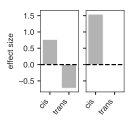

In [33]:
fig, axarr = plt.subplots(figsize=(1.5, 1.5), nrows=1, ncols=2, sharey=True)
human_ax = axarr[0]
mouse_ax = axarr[1]

sub = ex_sub[ex_sub["sp"] == "human"]
sns.barplot(data=sub, x="seq", y="value", ax=human_ax, color=sns.color_palette("Set2")[7])
human_ax.set_xticklabels(order, rotation=50, va="top", ha="right")
human_ax.set_ylabel("effect size")
human_ax.set_xlabel("")
human_ax.axhline(y=0, linestyle="dashed", color="black")

sub = ex_sub[ex_sub["sp"] == "mouse"]
sns.barplot(data=sub, x="seq", y="value", ax=mouse_ax, color=sns.color_palette("Set2")[7])
mouse_ax.set_xticklabels(order, rotation=50, va="top", ha="right")
mouse_ax.set_ylabel("")
mouse_ax.set_xlabel("")
mouse_ax.axhline(y=0, linestyle="dashed", color="black")
fig.savefig("Fig5A.pdf", dpi="figure", bbox_inches="tight")

### directional

In [34]:
ex = df[df["hg19_id"] == "h.1389"]
ex = ex[["hg19_id", "mm9_id", "minimal_biotype_hg19", "minimal_biotype_mm9", "HUES64_hg19", "HUES64_mm9",
         "mESC_hg19", "mESC_mm9", "trans_human_status_det", "fdr_trans_human", "trans_mouse_status_det", 
         "fdr_trans_mouse", "cis_HUES64_status_det", "fdr_cis_HUES64", "cis_mESC_status_det", "fdr_cis_mESC",
         "logFC_trans_human", "logFC_trans_mouse", "logFC_cis_HUES64", "logFC_cis_mESC"]]
ex

,hg19_id,mm9_id,minimal_biotype_hg19,minimal_biotype_mm9,HUES64_hg19,HUES64_mm9,mESC_hg19,mESC_mm9,trans_human_status_det,fdr_trans_human,trans_mouse_status_det,fdr_trans_mouse,cis_HUES64_status_det,fdr_cis_HUES64,cis_mESC_status_det,fdr_cis_mESC,logFC_trans_human,logFC_trans_mouse,logFC_cis_HUES64,logFC_cis_mESC
905,h.1389,m.1247,eRNA,eRNA,4.604656,1.173973,1.796721,1.049326,trans effect\n(higher in human),6.465697e-07,no trans effect,0.773881,cis effect\n(higher in human),2.416348e-10,no cis effect,0.274005,-0.768599,0.0626,-1.144567,-0.268827


In [35]:
ex = pd.melt(ex, id_vars=["hg19_id", "mm9_id", "minimal_biotype_hg19", "minimal_biotype_mm9"])
ex = ex[ex["variable"].isin(["HUES64_hg19", "HUES64_mm9", "mESC_hg19", "mESC_mm9",
                             "fdr_cis_HUES64", "fdr_cis_mESC",
                             "fdr_trans_human", "fdr_trans_mouse", "logFC_cis_HUES64", "logFC_cis_mESC",
                             "logFC_trans_human", "logFC_trans_mouse"])]

In [36]:
ex["cell"] = ex["variable"].str.split("_", expand=True)[0]
ex["seq"] = ex["variable"].str.split("_", expand=True)[1]
ex.head()

,hg19_id,mm9_id,minimal_biotype_hg19,minimal_biotype_mm9,variable,value,cell,seq
0,h.1389,m.1247,eRNA,eRNA,HUES64_hg19,4.60466,HUES64,hg19
1,h.1389,m.1247,eRNA,eRNA,HUES64_mm9,1.17397,HUES64,mm9
2,h.1389,m.1247,eRNA,eRNA,mESC_hg19,1.79672,mESC,hg19
3,h.1389,m.1247,eRNA,eRNA,mESC_mm9,1.04933,mESC,mm9
5,h.1389,m.1247,eRNA,eRNA,fdr_trans_human,6.4657e-07,fdr,trans


In [37]:
order = ["HUES64", "mESC"]
hue_order = ["hg19", "mm9"]
pal = {"hg19": sns.color_palette("Set2")[1], "mm9": sns.color_palette("Set2")[0]}

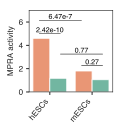

In [38]:
fig = plt.figure(figsize=(1.5, 1.5))

sub = ex[ex["cell"].isin(["HUES64", "mESC"])]
ax = sns.barplot(data=sub, x="cell", y="value", hue="seq", order=order, hue_order=hue_order, palette=pal)
ax.set_xticklabels(["hESCs", "mESCs"], rotation=50, va="top", ha="right")
ax.set_ylabel("MPRA activity")
ax.set_xlabel("")
ax.get_legend().remove()

ax.set_ylim((0, 7))
annotate_pval(ax, -0.25, 0.25, 5, 0, 5, ex[ex["variable"] == "fdr_cis_HUES64"]["value"].iloc[0], fontsize-1)
annotate_pval(ax, 0.75, 1.25, 2.25, 0, 2.25, ex[ex["variable"] == "fdr_cis_mESC"]["value"].iloc[0], fontsize-1)
annotate_pval(ax, -0.25, 0.75, 6.15, 0, 6.15, ex[ex["variable"] == "fdr_trans_human"]["value"].iloc[0], fontsize-1)
annotate_pval(ax, 0.25, 1.25, 3.25, 0, 3.25, ex[ex["variable"] == "fdr_trans_mouse"]["value"].iloc[0], fontsize-1)

# fig.savefig("directional_example_barplot.pdf", dpi="figure", bbox_inches="tight")

In [39]:
ex_sub = ex[ex["variable"].str.contains("logFC")]
ex_sub["sp"] = ex_sub["variable"].str.split("_", expand=True)[2]
ex_sub = ex_sub.sort_values(by=["seq", "sp"])
ex_sub["sp"] = ex_sub.apply(sp, axis=1)
ex_sub

,hg19_id,mm9_id,minimal_biotype_hg19,minimal_biotype_mm9,variable,value,cell,seq,sp
14,h.1389,m.1247,eRNA,eRNA,logFC_cis_HUES64,-1.14457,logFC,cis,human
15,h.1389,m.1247,eRNA,eRNA,logFC_cis_mESC,-0.268827,logFC,cis,mouse
12,h.1389,m.1247,eRNA,eRNA,logFC_trans_human,-0.768599,logFC,trans,human
13,h.1389,m.1247,eRNA,eRNA,logFC_trans_mouse,0.0625996,logFC,trans,mouse


In [40]:
order = ["cis", "trans"]

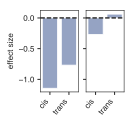

In [41]:
fig, axarr = plt.subplots(figsize=(1.5, 1.5), nrows=1, ncols=2, sharey=True)
human_ax = axarr[0]
mouse_ax = axarr[1]

sub = ex_sub[ex_sub["sp"] == "human"]
sns.barplot(data=sub, x="seq", y="value", ax=human_ax, color=sns.color_palette("Set2")[2])
human_ax.set_xticklabels(order, rotation=50, va="top", ha="right")
human_ax.set_ylabel("effect size")
human_ax.set_xlabel("")
human_ax.axhline(y=0, linestyle="dashed", color="black")

sub = ex_sub[ex_sub["sp"] == "mouse"]
sns.barplot(data=sub, x="seq", y="value", ax=mouse_ax, color=sns.color_palette("Set2")[2])
mouse_ax.set_xticklabels(order, rotation=50, va="top", ha="right")
mouse_ax.set_ylabel("")
mouse_ax.set_xlabel("")
mouse_ax.axhline(y=0, linestyle="dashed", color="black")
fig.savefig("Fig5B.pdf", dpi="figure", bbox_inches="tight")